In [1]:
import reciprocalspaceship as rs
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import os
import os.path
import gemmi as gm
import seaborn as sns
import re
from cycler import cycler
import matplotlib
import matplotlib.gridspec as gridspec
import glob
import shutil

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none',
    "font.size" : 16,
}
plt.rcParams.update(new_rc_params)


## get dataset names

In [2]:
file_pattern = './20221007_unscaled_unmerged/UCSF-P*/out_ohp.mtz'
files = glob.glob(file_pattern)
dataset_names = []
files.sort()
for name in files:
    dataset_names.append(name[-17:-12])

# Introduction

This notebook is for analyzing the results of careless outputs. We compile merging statistics for all `careless` runs as well as measure difference map peak heights and preparing scripts for plotting difference maps in pymol. 

We compute $CC_\text{pred}$, the correlation coefficient between the observed and `careless`-predicted structure factors. We plot this statistics as a function of the double-Wilson $r$ value. Then, we find the tallest positive peak in each of the difference maps per careless run and plot the max positive peak height per dataset as a function of $r$. Finally, we find the best $r$ value for each holo dataset, copy the corresponding merged MTZ to a new folder, and run pymol to obtain snapshots of the difference maps.

We start with defining a function that reads the `careless` input parameters. 

In [3]:
def get_careless_params(dirpath):
#     print(os.path.join(dirpath, 'inputs_params.log'))
    with open(os.path.join(dirpath, 'inputs_params.log')) as params:
        line = params.readline()
        line = params.readline()
        args_list=line.split('--')
#             print(args_list)
        p_={}
        bDisableImageScale=False
        for tag in args_list:
            if 'dmin' in tag:
                p_['DMIN']=tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-frequencies' in tag:
                p_['PEF'] =tag.split('=')[1].split(' ')[0]
            if 'iterations' in tag:
                p_['ITER']=tag.split('=')[1].split(' ')[0]
            if 'mlp-layers' in tag:
                p_['MLPL']=tag.split('=')[1].split(' ')[0]
                run_param.MLPL  = run_param.MLPL.astype( 'int64')
            if 'studentt-likelihood-dof' in tag:
                p_['STDOF'] =tag.split('=')[1].split(' ')[0]
            if 'image-layers' in tag:
                p_['IL']  =tag.split('=')[1].split(' ')[0]
            if 'positional-encoding-keys' in tag:
                p_['PE-keys']=tag.split('=')[1].split(' ')[0]
            if 'seed' in tag:
                p_['SEED']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-parents' in tag:
                p_['DW_list']=tag.split('=')[1].split(' ')[0]
            if 'double-wilson-r' in tag:
                DWr_list = tag.split('=')[1]
                p_['rDW']  = DWr_list.split(',')[-1]
            if 'disable-image-scales' in tag:
                bDisableImageScale=True
            if 'refine-uncertainties' in tag:
                p_['RU']=1
        if bDisableImageScale:
            p_['IL']=-1
        if 'STDOF' not in p_:
            p_['STDOF']=-1
        if 'RU' not in p_:
            p_['RU']=0
        if 'PEF' not in p_:
            p_['PEF']=0
        if 'rDW' not in p_:
            p_['rDW']=-1
        run_param=pd.DataFrame(data=p_,index=[0])
        run_param.DMIN  = run_param.DMIN.astype( 'float')
        run_param.SEED  = run_param.SEED.astype( 'int64')
        run_param.ITER  = run_param.ITER.astype( 'int64')
        run_param.STDOF = run_param.STDOF.astype('float')
        run_param.RU    = run_param.RU.astype(   'int64')
        run_param.IL    = run_param.IL.astype(   'int64')
        run_param.rDW   = run_param.rDW.astype(  'float')
        run_param.PEF   = run_param.PEF.astype(  'int64')
        return run_param

### Importing $CC_\text{pred}$ and $CC_\text{1/2}$

First, we run `make_diffmap.sh`, which uses `reciprocalspaceship` to compute difference maps and compute peak heights. 

In [11]:
%%bash 

sh scripts/make_diffmap_all.sh merge_2037* #set this argument to the directories corresponding to your careless outputs. 

careless_runs/merge_23799837_27328_mono_mc1_10k_grid_11
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23799837_27328_mono_mc1_10k_grid_11
1
Submitted batch job 24045621
careless_runs/merge_23801023_1060_mono_mc1_10k_grid_10
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801023_1060_mono_mc1_10k_grid_10
1
Submitted batch job 24045622
careless_runs/merge_23801039_28161_mono_mc1_10k_grid_2
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801039_28161_mono_mc1_10k_grid_2

Submitted batch job 24045623
careless_runs/merge_23801270_13441_mono_mc1_10k_grid_3
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801270_13441_mono_mc1_10k_grid_3

Submitted batch job 24045624
careless_runs/merge_23801560_19364_mono_mc1_10k_grid_4
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801560_19364_m

In [12]:
%%bash
sh scripts/run_ccs_all.sh merge_2037*

careless_runs/merge_23799837_27328_mono_mc1_10k_grid_11
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23799837_27328_mono_mc1_10k_grid_11
1
careless_runs/merge_23801023_1060_mono_mc1_10k_grid_10
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801023_1060_mono_mc1_10k_grid_10
1
careless_runs/merge_23801039_28161_mono_mc1_10k_grid_2
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801039_28161_mono_mc1_10k_grid_2

careless_runs/merge_23801270_13441_mono_mc1_10k_grid_3
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801270_13441_mono_mc1_10k_grid_3

careless_runs/merge_23801560_19364_mono_mc1_10k_grid_4
/net/holy-nfsisilon/ifs/rc_labs/hekstra_lab/projects/dw-examples/dfs/careless_runs/merge_23801560_19364_mono_mc1_10k_grid_4

careless_runs/merge_23801561_8689_mono_mc1_10k_grid_5
/net/holy-nfsisilon/ifs/rc_labs/hekstra_la

In [4]:
#some metrics on the peak heights per dataset
def peak_sum(heights):
    heights = np.array(heights)
    return np.sum(heights[heights>0])

def tallest_pos_height(heights):
    heights = np.array(heights)
    
    try:
        return heights[heights>0][0]
    except:
        return np.nan

We import and clean the `.csv` files containing $CC_\text{pred}$ and $CC_\text{1/2}$ statistics for each careless run.

In [5]:
count=0
results_list=[]
params_list=[]
id_list=[]

search_pattern="careless_runs"
for dirpath, dirnames, filenames in os.walk("."):
    if ('ccpred_overall_careless.csv' in filenames) and (search_pattern in dirpath):
        tmp=pd.read_csv(os.path.join(dirpath, 'ccpred_overall_careless.csv'))
#         print(tmp)
        try:
            print(dirpath)
#             for i in range(10):
#                 print(f"i: {i}, {dirpath.split('_')[-1*i]}")
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
#             tmp_r=np.nan
        tmp["grid_id"]=tmp_id
        tmp["job_id"]=job_id
        tmp["seed"]=seed
#         print('----------')
#         print(dirpath)
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        results_list.append(tmp)
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)

all_params =pd.concat(params_list)
all_results_ccpred=pd.concat(results_list)

./careless_runs/merge_20379811_3528_mono_mc1_10k_grid_9
Read-in values of grid_id: 9,  job_id: 20379811,  seed: 3528
./careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
Read-in values of grid_id: 11,  job_id: 20379920,  seed: 12673
./careless_runs/merge_20379915_20830_mono_mc1_10k_grid_6
Read-in values of grid_id: 6,  job_id: 20379915,  seed: 20830
./careless_runs/merge_20379917_9008_mono_mc1_10k_grid_7
Read-in values of grid_id: 7,  job_id: 20379917,  seed: 9008
./careless_runs/merge_20379919_22723_mono_mc1_10k_grid_10
Read-in values of grid_id: 10,  job_id: 20379919,  seed: 22723
./careless_runs/merge_20379913_17439_mono_mc1_10k_grid_4
Read-in values of grid_id: 4,  job_id: 20379913,  seed: 17439
./careless_runs/merge_20379914_10904_mono_mc1_10k_grid_5
Read-in values of grid_id: 5,  job_id: 20379914,  seed: 10904
./careless_runs/merge_20379918_5300_mono_mc1_10k_grid_2
Read-in values of grid_id: 2,  job_id: 20379918,  seed: 5300
./careless_runs/merge_20379916_11942_mono_mc1_10k_

In [6]:
all_results_ccpred = pd.melt(all_results_ccpred, id_vars=['file', 'grid_id','job_id','Resolution Range (Å)','seed','test'], value_vars=['CCpred'])
all_results_ccpred.rename(columns={'value': 'CCpred'}, inplace=True)
pivoted_df = all_results_ccpred.pivot(index=['file', 'grid_id','job_id','Resolution Range (Å)','seed'], columns='test', values='CCpred')
pivoted_df.rename(columns={'Test': 'CCpred_test','Train': 'CCpred_train'}, inplace=True)
all_results_ccpred = pivoted_df.reset_index()

In [7]:
all_params.reset_index(drop=True,inplace=True)
all_results_ccpred.dropna(inplace=True)
all_results_ccpred["dataset"] = [os.path.splitext(name)[0].split('_')[-1] for name in all_results_ccpred.file]
all_results_ccpred["dataset"]=all_results_ccpred["dataset"].astype('int32')
all_results_ccpred["dataset"]=["off" if i<2 else dataset_names[i-2] for i in all_results_ccpred["dataset"]]
all_results_ccpred.sort_values(by=["grid_id","job_id"],inplace=True)
all_results_ccpred.reset_index(inplace=True)
print(all_results_ccpred.count())
all_results = all_results_ccpred

test
index                   180
file                    180
grid_id                 180
job_id                  180
Resolution Range (Å)    180
seed                    180
CCpred_test             180
CCpred_train            180
dataset                 180
dtype: int64


In [8]:
all_results_ccpred_avg = all_results_ccpred[["grid_id","job_id","CCpred_test","CCpred_train","dataset"]].groupby(by=["grid_id"])
all_results_ccpred_avg = all_results_ccpred_avg.agg({"CCpred_test":"mean",
                                                     "CCpred_train":"mean",
                                                     "job_id":"first",
                                                     "dataset":"first"})


In [9]:
df_param=all_params[['IL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_results_ccpred_avg.loc[(all_results_ccpred_avg["job_id"]==job_id), column] =\
        df_param.loc[(df_param["job_id"]==job_id),column].to_numpy()[0]

all_results=all_results_ccpred_avg.infer_objects()
all_results=all_results.sort_values(by=["rDW"])

tmp=all_results.loc[:,\
                      ["dataset","CCpred_train","CCpred_test",
                       "grid_id","job_id","IL","ITER","STDOF","PEF","rDW","RU"]].groupby(\
                      ["job_id","IL","ITER","STDOF","PEF","rDW","RU","dataset"]).mean().reset_index().sort_values(by=["rDW"])
all_results_ccpred_avg=tmp

# all_results_avg.set_index("grid_id",inplace=True)
#all_results_avg.style.background_gradient()
all_results_ccpred_avg

test,job_id,IL,ITER,STDOF,PEF,rDW,RU,dataset,CCpred_train,CCpred_test,grid_id
7,20379918,0.0,10000.0,16.0,5.0,-1.00000,0.0,off,0.915543,0.903755,2.0
1,20379830,0.0,10000.0,16.0,5.0,0.00000,0.0,off,0.915572,0.904156,3.0
2,20379913,0.0,10000.0,16.0,5.0,0.50000,0.0,off,0.919971,0.910062,4.0
3,20379914,0.0,10000.0,16.0,5.0,0.75000,0.0,off,0.921192,0.913648,5.0
4,20379915,0.0,10000.0,16.0,5.0,0.87500,0.0,off,0.920758,0.913853,6.0
6,20379917,0.0,10000.0,16.0,5.0,0.93750,0.0,off,0.919861,0.914012,7.0
5,20379916,0.0,10000.0,16.0,5.0,0.96875,0.0,off,0.918543,0.914190,8.0
0,20379811,0.0,10000.0,16.0,5.0,0.98438,0.0,off,0.916564,0.912656,9.0
8,20379919,0.0,10000.0,16.0,5.0,0.99218,0.0,off,0.914515,0.911688,10.0
9,20379920,0.0,10000.0,16.0,5.0,0.99610,0.0,off,0.911906,0.909616,11.0


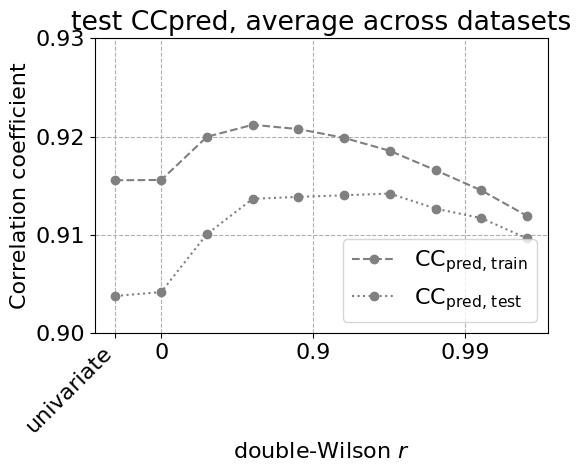

In [10]:
tmp = all_results_ccpred_avg
fig,ax = plt.subplots(figsize=[6,5])
plt.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_train"],'o--',color="gray",label=r"CC$_\text{pred, train}$")
plt.plot(np.log10(1-tmp["rDW"]),tmp["CCpred_test"],'o:',color="gray",label=r"CC$_\text{pred, test}$")

plt.grid(linestyle="--")
plt.title("test CCpred, average across datasets")
plt.legend(loc="lower right")
plt.xlabel("double-Wilson $r$")
plt.ylabel("Correlation coefficient")
plt.gca().invert_xaxis()
plt.xticks(ticks=[-2,-1,0,0.303],labels=["0.99","0.9","0","univariate"])
plt.ylim([0.9,0.93])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
#ax.legend(loc='lower right')
plt.tight_layout()
plt.savefig("CCs.svg",bbox_inches="tight")
plt.show()

In [11]:
count=0
results_list=[]
params_list=[]
id_list=[]


search_pattern="careless_runs"
for dirpath, dirnames, filenames in os.walk("."):
    if ('out_P0115_noweights_scaled.csv' in filenames) and (search_pattern in dirpath):
        try:
            print(dirpath)
            tmp_id=int(dirpath.split('_')[-1])
            job_id=int(dirpath.split('_')[-7]) # appropriate index may vary from run to run!
            seed=int(dirpath.split('_')[-6])   # appropriate index may vary from run to run!
        except:
            print(dirpath.split('_')[-1])
        for j,holo in enumerate(dataset_names[:16]):
            stats = pd.read_csv(os.path.join(dirpath, f"out_{holo}_noweights_scaled.csv"))
            heights = stats[stats["residue"]=="LIG"]
            #heights = heights["peakz"][:5].to_numpy().round(decimals=2)
            heights = tallest_pos_height(heights["peakz"][:5].to_numpy().round(decimals=2))
            
            tmp=pd.DataFrame({"heights":[heights],"dataset name":holo,
                              "grid_id":tmp_id,"job_id":job_id,
                              "seed":seed}, index=[j])
            results_list.append(tmp)
            
        print(f"Read-in values of grid_id: {tmp_id},  job_id: {job_id},  seed: {seed}")
        careless_params=get_careless_params(dirpath)
        careless_params["grid_id"]=tmp_id
        careless_params["job_id"]=job_id
        careless_params["seed"]=seed
        params_list.append(careless_params)


all_params =pd.concat(params_list)
all_heights = pd.concat(results_list)

./careless_runs/merge_20379811_3528_mono_mc1_10k_grid_9
Read-in values of grid_id: 9,  job_id: 20379811,  seed: 3528
./careless_runs/merge_20379920_12673_mono_mc1_10k_grid_11
Read-in values of grid_id: 11,  job_id: 20379920,  seed: 12673
./careless_runs/merge_20379915_20830_mono_mc1_10k_grid_6
Read-in values of grid_id: 6,  job_id: 20379915,  seed: 20830
./careless_runs/merge_20379917_9008_mono_mc1_10k_grid_7
Read-in values of grid_id: 7,  job_id: 20379917,  seed: 9008
./careless_runs/merge_20379919_22723_mono_mc1_10k_grid_10
Read-in values of grid_id: 10,  job_id: 20379919,  seed: 22723
./careless_runs/merge_20379913_17439_mono_mc1_10k_grid_4
Read-in values of grid_id: 4,  job_id: 20379913,  seed: 17439
./careless_runs/merge_20379914_10904_mono_mc1_10k_grid_5
Read-in values of grid_id: 5,  job_id: 20379914,  seed: 10904
./careless_runs/merge_20379918_5300_mono_mc1_10k_grid_2
Read-in values of grid_id: 2,  job_id: 20379918,  seed: 5300
./careless_runs/merge_20379916_11942_mono_mc1_10k_

In [12]:
all_params.reset_index(drop=True,inplace=True)
all_heights.dropna(inplace=True)
all_heights.sort_values(by=["grid_id","job_id"],inplace=True)
all_heights.reset_index(inplace=True)
all_heights.drop(columns="index", inplace=True)
print(all_heights.count())
all_heights.head()

heights         155
dataset name    155
grid_id         155
job_id          155
seed            155
dtype: int64


,heights,dataset name,grid_id,job_id,seed
0,28.10,P0115,2,20379918,5300
1,6.45,P0116,2,20379918,5300
2,6.19,P0123,2,20379918,5300
3,9.86,P0124,2,20379918,5300
4,13.27,P0131,2,20379918,5300


In [13]:
df_param=all_params[['IL','ITER','STDOF','PEF','rDW','RU','grid_id','job_id','seed']].copy()

for ix, row in df_param.iterrows():
    grid_id=int(row["grid_id"])
    job_id =int(row["job_id"])
    for column in df_param.columns:
        all_heights.loc[(all_heights["grid_id"]==grid_id) & (all_heights["job_id"]==job_id), column] =\
        df_param.loc[(df_param["grid_id"]==grid_id) & (df_param["job_id"]==job_id),column].to_numpy()[0]

all_heights=all_heights.infer_objects()
all_heights=all_heights.sort_values(by=["dataset name","rDW"])
all_heights=all_heights.reset_index()
all_heights=all_heights.drop(columns=["index"])


In [15]:
temp = all_heights[all_heights["grid_id"]==9].copy()
temp["grid_id"]=17
temp["rDW"]=-3
for dataset in dataset_names:
    stats = pd.read_csv(f"./20221007_unscaled_unmerged/UCSF-{dataset}/out_{dataset}_pandda.csv")
    heights = stats[stats["residue"]=="LIG"]
    heights = tallest_pos_height(heights["peakz"][:5].to_numpy().round(decimals=2))
    temp.loc[temp["dataset name"]==dataset,"heights"]=heights
print(temp)

     heights dataset name  grid_id    job_id  seed   IL     ITER  STDOF  PEF  \
7      35.29        P0115       17  20379811  3528  0.0  10000.0   16.0  5.0   
17      8.41        P0116       17  20379811  3528  0.0  10000.0   16.0  5.0   
27     14.45        P0123       17  20379811  3528  0.0  10000.0   16.0  5.0   
37     20.72        P0124       17  20379811  3528  0.0  10000.0   16.0  5.0   
47      9.61        P0131       17  20379811  3528  0.0  10000.0   16.0  5.0   
57     19.73        P0132       17  20379811  3528  0.0  10000.0   16.0  5.0   
67     19.02        P0137       17  20379811  3528  0.0  10000.0   16.0  5.0   
77     28.94        P0138       17  20379811  3528  0.0  10000.0   16.0  5.0   
87     13.79        P0139       17  20379811  3528  0.0  10000.0   16.0  5.0   
92      6.96        P0142       17  20379811  3528  0.0  10000.0   16.0  5.0   
102    11.18        P0148       17  20379811  3528  0.0  10000.0   16.0  5.0   
112    37.16        P0159       17  2037

# plot the peak heights as a function of the double Wilson r

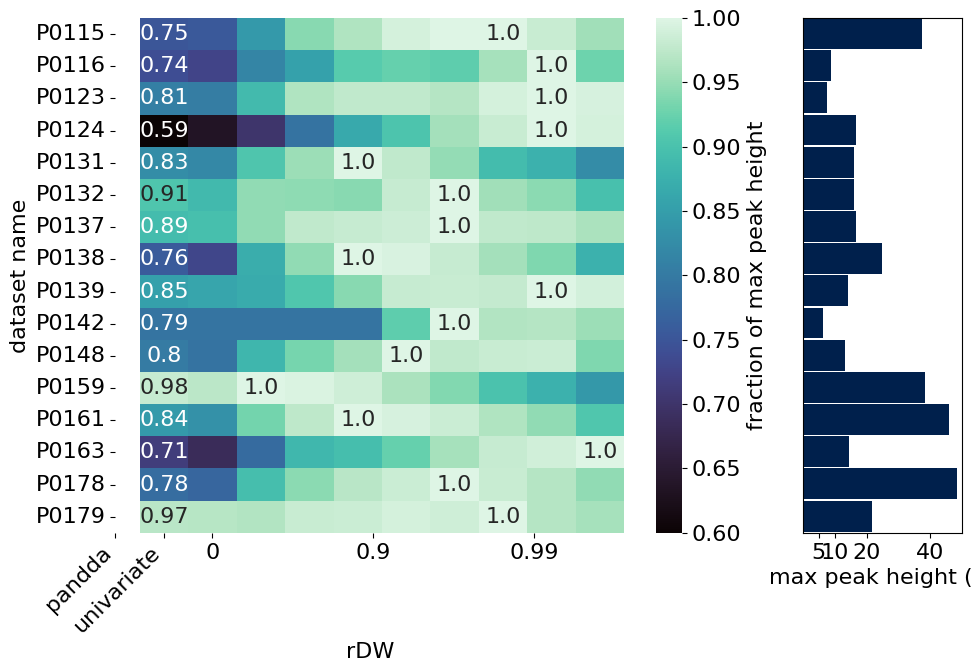

In [17]:
table = all_heights[["rDW","dataset name","heights"]].pivot_table(index='dataset name', columns='rDW', values='heights')
table.fillna(5, inplace=True) #diffmap peak heights are cut at 5sigma, so any NaNs are filled with value of 5. 
max_table = table.max(axis="columns").to_numpy()
table = table.div(max_table, axis='rows')


def threshold(x):
    return '' if x<1 else np.round(x,1)
table_labels = table.applymap(threshold)
table_labels[-1.0] = np.round(table.iloc[:,0],2)

fig = plt.figure(figsize=(10, 7))
gs = gridspec.GridSpec(1, 2, width_ratios=[0.8, 0.2])

ax1 = plt.subplot(gs[0])
sns.heatmap(table, ax=ax1, 
            cmap="mako",
            cbar_kws={'label': 'fraction of max peak height'},
            annot=table_labels,
            annot_kws={"fontsize":16},
            fmt = '')


xticks = (1.5-np.log2(1-np.array([-3,-1,0,0.9,0.99])))/len(table.columns)
ax1.set_xticks(xticks*ax1.get_xlim()[1])
ax1.set_xticklabels(["pandda","univariate","0","0.9","0.99"])

ticks = ax1.get_xticklabels()
for ind,tick in enumerate(ticks):
    if ind == 0 or ind == 1:
        tick.set_rotation(45)
        tick.set_ha("right")
    else:
        tick.set_rotation(0)

ax1.collections[0].set_clim(0.6,1) 

ax2 = plt.subplot(gs[1], sharey=ax1)
ax2.barh(table.index, max_table, color='#00204c', height=0.96, align='edge')
ax2.tick_params(left=False, labelleft=False)
#ax2.set_xscale("log")
ax2.set_xlim([0,50])
ax2.set_xticks([5,10,20,40])
ax2.set_xticklabels([5,10,20,40])
ax2.set_xlabel('max peak height (σ)')
plt.tight_layout()
plt.savefig("peak_heights_scaled.svg",bbox_inches="tight")

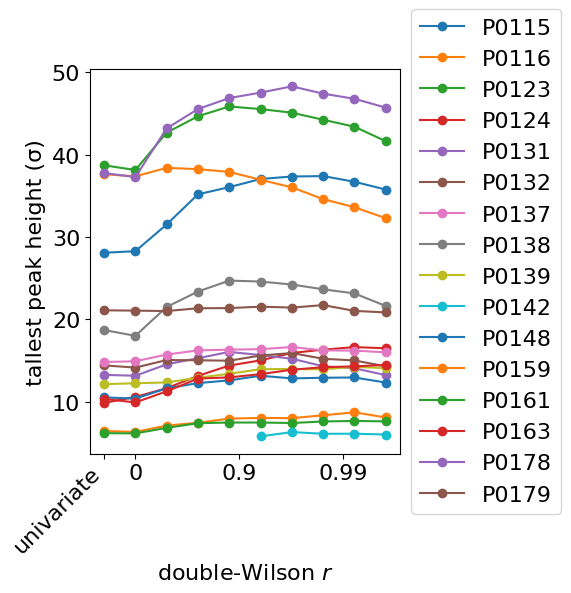

In [15]:

fig,ax = plt.subplots(figsize=(4,5))

for dataset in dataset_names[:16]:
    cut = all_heights[all_heights["dataset name"]==dataset]
    plt.plot(np.log10(1-cut.loc[:,"rDW"]),\
         cut.loc[:,"heights"],'o-',label=dataset)    
plt.xlabel("double-Wilson $r$")
plt.xticks(ticks=[-2,-1,0,0.303],labels=["0.99","0.9","0","univariate"])
ticks = ax.get_xticklabels()
ticks[-1].set_rotation(45)
ticks[-1].set_ha("right")
plt.ylabel("tallest peak height (σ)")
plt.gca().invert_xaxis()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("peakheights.svg",dpi=600,bbox_inches="tight")
plt.show()

### Save the grid_ids that correspond to the maximum peak height

In [18]:
max_height_indices = all_heights.groupby('dataset name')['heights'].idxmax()

# Get the corresponding parameters for the maximum height rows
result = all_heights.loc[max_height_indices, ['dataset name', 'heights','grid_id','rDW','job_id']].reset_index(drop=True)
print(result)

try:
    os.mkdir("pymol_dfs")
except:
    pass

os.chdir("pymol_dfs")
univariate_dir = glob.glob(f"../careless_runs/merge_*_mono_mc1_10k_grid_2")[0]

##check these copy statements to make sure the right ones are copied!!
for i,row in result.iterrows():
    mtz_dir = glob.glob(f"../careless_runs/merge_{row.job_id}_*_mono_mc1_10k_grid_{row.grid_id}")
    shutil.copy(f"{mtz_dir[0]}/wdm_{i+2}_scaled.mtz", f"./wdm_{i+2}_best.mtz")
    shutil.copy(f"{univariate_dir}/wdm_{i+2}_scaled.mtz",f"./wdm_{i+2}_univariate.mtz")
    shutil.copy(f"../20221007_unscaled_unmerged/UCSF-{row['dataset name']}/UCSF-{row['dataset name']}-pandda-model.pdb",
               f"UCSF-{row['dataset name']}-pandda-model_{i+2}.pdb")

   dataset name  heights  grid_id      rDW    job_id
0         P0115    37.41        9  0.98438  20379811
1         P0116     8.72       10  0.99218  20379919
2         P0123     7.67       10  0.99218  20379919
3         P0124    16.64       10  0.99218  20379919
4         P0131    16.06        6  0.87500  20379915
5         P0132    15.92        8  0.96875  20379916
6         P0137    16.65        8  0.96875  20379916
7         P0138    24.72        6  0.87500  20379915
8         P0139    14.24       10  0.99218  20379919
9         P0142     6.32        8  0.96875  20379916
10        P0148    13.16        7  0.93750  20379917
11        P0159    38.41        4  0.50000  20379913
12        P0161    45.87        6  0.87500  20379915
13        P0163    14.48       11  0.99610  20379920
14        P0178    48.31        8  0.96875  20379916
15        P0179    21.74        9  0.98438  20379811


## Correlate the grid_ids with 1-BDC

In [17]:
result["1-BDC"] = [0.14, 0.1, 0.13, 0.1, 0.17, 0.17, 
                   0.18, 0.13, 0.2, 0.07, 0.19, 0.36, 
                   0.27, 0.14, 0.16, 0.33]

          log_dw     1-BDC
log_dw  1.000000  0.504951
1-BDC   0.504951  1.000000


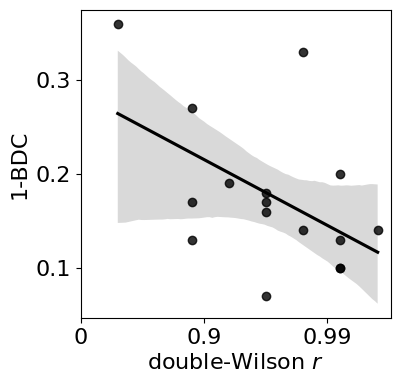

In [18]:
fig, ax = plt.subplots(figsize=[4,4])
result["log_dw"] = np.log10(1-result["rDW"])
sns.regplot(data=result, x="log_dw", y="1-BDC",ax=ax, color="k")
plt.ylabel(r"1-BDC")
plt.xlabel(r"double-Wilson $r$")
print(result[["log_dw","1-BDC"]].corr())
plt.xticks(ticks=[-2,-1,0],labels=["0.99","0.9","0"])
plt.gca().invert_xaxis()
plt.savefig("../bdc_rdw_corr_new.svg", bbox_inches="tight")

## write and execute pymol scripts for making images

In [ ]:
for num, dataset in enumerate(dataset_names[:16]):
    careless_num = num+2
    os.system(f"sed 's/dataset=\"P0115\"/dataset=\"{dataset}\"/g' pymol_template.pml > pymol_{careless_num}.pml")
    os.system(f"sed -i 's/num=2/num={careless_num}/g' pymol_{careless_num}.pml")
    
    #on dataset 11, we make the difference map more clear by contouring at 2σ. 
    if careless_num == 11:
        os.system(f"sed -i 's/3.0, ligand/2.0, ligand/g' pymol_{careless_num}.pml")
        
    #on dataset 16, we set the view differently.     
    if careless_num == 16:
        os.system(f"sed -i 's/(-0.9199408888816833, 0.34247779846191406, -0.1907799392938614, -0.2290385514497757, -0.07459352910518646, 0.9705454111099243, 0.31816330552101135, 0.9365552067756653, 0.14706364274024963, 0.0, 0.0, -39.80332946777344, -44.95423126220703, -29.24036407470703, 2.3783278465270996, 34.238868713378906, 45.36779022216797, -20.0)/(0.15932810306549072, 0.7754020690917969, -0.611018180847168, -0.7061164379119873, 0.5220480561256409, 0.4783775210380554, 0.6899275183677673, 0.3552376925945282, 0.6307111382484436, 0.0, 0.0, -39.80332946777344, -44.78321075439453, -28.825420379638672, 0.8955264091491699, 35.08838653564453, 44.518272399902344, -20.0)/g' pymol_{careless_num}.pml")
    os.system(f"pymol pymol_{careless_num}.pml")